In [1]:
import requests
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

from typing import Any
from collections import Counter
from bs4 import BeautifulSoup
from nltk.corpus import inaugural, stopwords
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.sentiment.vader import SentimentIntensityAnalyzer

/Users/jesidacosta/.local/share/virtualenvs/ISM6930-CY7GBNHA/lib/python3.9/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


# Sourcing Data

**Note:** Data for Biden's speech (2021-Biden.txt) was manually sourced and copied in to filepath of NLTK data (/Users/<UserName>/nltk_data/inaugural)

Create a corpus of inaugural speeches of all US Presidents, available from the Miller Center's website (https://millercenter.org/the-presidency/presidential-speeches (Links to an external site.)) or from NLTK's "inaugural" corpus. If the inaugural corpus does not have President Biden's 2021 speech, you will have to add that speech to your data. Add to the corpus the year of the speech and the president’s party affiliation as: Democrat, Republican, or Other. Analyze the textual content of these speeches to answer the following questions.

In [2]:
""" Function to creates speeches data frame. VanBuren is split into two words: Van Buren"""

def create_presidential_data() -> pd.DataFrame:
    """Creates a dataframe with the speech data."""
    # initializing dataframe
    columns = ['fileid', 'last_name', 'speech_year', 'raw_text']
    data = pd.DataFrame(columns=columns)
    # appending
    for fileid in inaugural.fileids():
        id = fileid
        last_name = fileid.replace('.txt', '').split('-')[1]
        if last_name == 'VanBuren':
            last_name = 'Van Buren'
        year = int(fileid.split('-')[0])
        # get text
        text = inaugural.raw(fileid)
        # create temp with new row
        row = [[id, last_name, year, text]]
        temp = pd.DataFrame(row, columns=columns)
        # print(row)
        # add new row to main data
        data = data.append(temp, ignore_index=True)
    return data 

"""Getting the data from nltk inagural package"""

data = create_presidential_data()
data.head()

,fileid,last_name,speech_year,raw_text
0,1789-Washington.txt,Washington,1789,Fellow-Citizens of the Senate and of the House...
1,1793-Washington.txt,Washington,1793,"Fellow citizens, I am again called upon by the..."
2,1797-Adams.txt,Adams,1797,"When it was first perceived, in early times, t..."
3,1801-Jefferson.txt,Jefferson,1801,Friends and Fellow Citizens:\n\nCalled upon to...
4,1805-Jefferson.txt,Jefferson,1805,"Proceeding, fellow citizens, to that qualifica..."


### Adding Presidential Party

In [3]:
""" Getting Party names from Britannica Website."""

# Fetching data from website
url = "https://www.britannica.com/topic/Presidents-of-the-United-States-1846696"
response = requests.get(url)
# Parsing html
soup = BeautifulSoup(response.text, 'lxml')
soup.title
# Fetching table from parsed html
table = soup.find('table')


def get_party_names(html_table, two_parties:bool=True) -> pd.DataFrame:
    """Creates a dataframe from html table with each president and corresponding party.
        - html_table: table to be converted to dataframe
        - two_parties: if True denotes older parties as other; default = True
    """
    columns = ['name', 'party', 'start', 'end']
    presidents = pd.DataFrame(columns=columns)
    for row in html_table.find_all('tr'):
        cells = row.find_all('td')
        # only counting data with 6 fields
        if len(cells) == 6:
            name = cells[2].text.strip()
            party = cells[4].text.strip()
            # Creating only 3 labels: Dem, Rep, Other
            if two_parties:
                if party in ['Democratic', 'Democratic (Union)']:
                    party = 'Democratic'
                elif party in ['Republican']:
                    party = 'Republican'
                else:
                    party = 'Other'
            else:
                party = party
            term = cells[5].text.strip().replace('*','')
            # case one year terms
            if '–' not in term:
                start = int(term)
                end = start
            # case change of centuries
            elif len(term) == 9:
                start = int(term.split('–')[0])
                end = int(term.split('–')[1])
            else:
                # removing resigned or died symbols
                start = int(term.split('–')[0])
                # case for current president
                if term.endswith('–') and start <= dt.datetime.now().year:
                    # assuming short term case 
                    end = start + 4
                else:
                    # adding 2 digit year prefix
                    end = int(term[:2] + term.split('–')[1])
            # adding presidents
            row = [[name, party, start, end]]
            temp = pd.DataFrame(row, columns=columns)
            presidents = presidents.append(temp, ignore_index=True)
    return presidents


def add_parties(data:pd.DataFrame, parties:pd.DataFrame) -> pd.DataFrame:
    """Matches party to existing data with speech text by year of term and name of president.
        - data: dataframe with speeches
        - parties: dataframe with parties and president terms
    
    Returns: consolidated dataframe with party and full name

    """
    for index, row in data.iterrows():
        # get year and name
        last_name = row['last_name']
        speech_year = row['speech_year']
        # match name and year
        filter = parties.name.str.contains(last_name) &  parties.start.le(speech_year) & parties.end.ge(speech_year)
        matched = parties[filter]
        # add full name and party
        data.loc[index, 'full_name'] = matched['name'].values[0]
        data.loc[index, 'party'] = matched['party'].values[0]
    return data

In [4]:
# creates df with parties
parties = get_party_names(table)
# adding parties & text together
df = add_parties(data, parties)
# dropping last_name
df = df.drop(columns=['last_name'])
df.head()

,fileid,speech_year,raw_text,full_name,party
0,1789-Washington.txt,1789,Fellow-Citizens of the Senate and of the House...,George Washington,Other
1,1793-Washington.txt,1793,"Fellow citizens, I am again called upon by the...",George Washington,Other
2,1797-Adams.txt,1797,"When it was first perceived, in early times, t...",John Adams,Other
3,1801-Jefferson.txt,1801,Friends and Fellow Citizens:\n\nCalled upon to...,Thomas Jefferson,Other
4,1805-Jefferson.txt,1805,"Proceeding, fellow citizens, to that qualifica...",Thomas Jefferson,Other


In [5]:
# save as csv
# df.to_csv('speeches.csv', index=False)

# read from csv
# df = pd.read_csv('speeches.csv', index=False)

# Questions

## 1. Which president has the most vocabulary as evident from their inaugural speeches, and which presidents has the least vocabulary? On average, do Democratic, Republican, or Other presidents have higher vocabulary? (2 points)

In [6]:
"""We first created a function to preprocess/clean text, another to get the word frequency and a helper function to add this to our dataframe."""

def preprocess_text(raw_text:str) -> str:
    """
    Preprocesses raw text by checking for corner cases, removing punctuation and stopwords.
        - raw_text(str): text to be cleaned
    
    Returns: string of cleaned text 
    """
    # additional stop words
    add_stopwords = ['us']
    # corner case if U.S. => rename united_states
    if set(['U.S.', 'US']).issubset(raw_text):
        print('U.S. word present: TRUE')
        raw_text = re.sub("|".join(['U.S.', 'US']), 'united_states', raw_text)
    # remove punctuation
    text = re.sub(r'[^\w\s]', ' ', raw_text)
    # lower case and pass to list
    word_list = [word.lower() for word in text.split()]
    # remove stop words
    stop_words = stopwords.words('english') + add_stopwords
    word_list = [word for word in word_list if word not in stop_words]
    # cleaned text
    new_text = " ".join(word_list)
    return new_text

def get_word_frequency(clean_text:str, lemmatize:bool=True) -> Counter:
    """
    Gets the word frequency given a cleaned text file.
        - clean_text(str): preprocessed text
        - lemmatize(bool): gives common parent of each word, bringing words back to their cannonical root, default=True
    
    Returns: Counter of all words
    """
    # format to word list
    words = [w for w in clean_text.split()]
    # lemmatize words
    if lemmatize:
        wordnet = WordNetLemmatizer()
        words = [wordnet.lemmatize(w) for w in words]
    # create counter
    counts = Counter(words)
    # print('counts:',len(counts))
    return counts

# get_word_frequency(clean_text, LEMMATIZE).most_common(5)

def add_vocab_info(df:pd.DataFrame, lemmatize) -> pd.DataFrame:
    """Helper function adds vocab information to dataframe"""
    for index, row in df.iterrows():
        raw_text = row['raw_text']
        clean_text = preprocess_text(raw_text)
        frequency = get_word_frequency(clean_text, lemmatize=lemmatize)
        # store values
        word_counts = len(frequency)
        top_five = frequency.most_common(5)
        df.loc[index, "vocab_count"] = word_counts
        df.loc[index, "top_words"] = str(top_five)
    return df


As exhibited by each inagural speech the presidents with:
- Most vocabulary: **William Harrison, 1841**
- Least Vocabulary: **George Washigton, 1793**

When looking at the averge number of vocabulary by each party the **Republican** party has most with 681 words

In [7]:
# Parameter to lemmatize before doing frequency counts 
LEMMATIZE = True


# get vocab info and 
df = add_vocab_info(df, lemmatize=LEMMATIZE)
# sort values in descending order
sorted_df = df.sort_values('vocab_count', ascending=False)
# show first and last
sorted_df.iloc[[0,-1]][['full_name', 'speech_year', 'vocab_count']]

,full_name,speech_year,vocab_count
13,William Henry Harrison,1841,1560.0
1,George Washington,1793,57.0


In [8]:
# get average by party
sorted_df.groupby('party').mean('vocab_count').sort_values('vocab_count', ascending=False)

,vocab_count
party,
Republican,681.333333
Other,660.916667
Democratic,590.782609


## 2. Create a barplot of presidential vocabulary from the earliest president (Washington) to the latest (Trump) in chronological order. Color code this barplot as blue for Democrat, red for Republican, and gray for Others. (1 point)


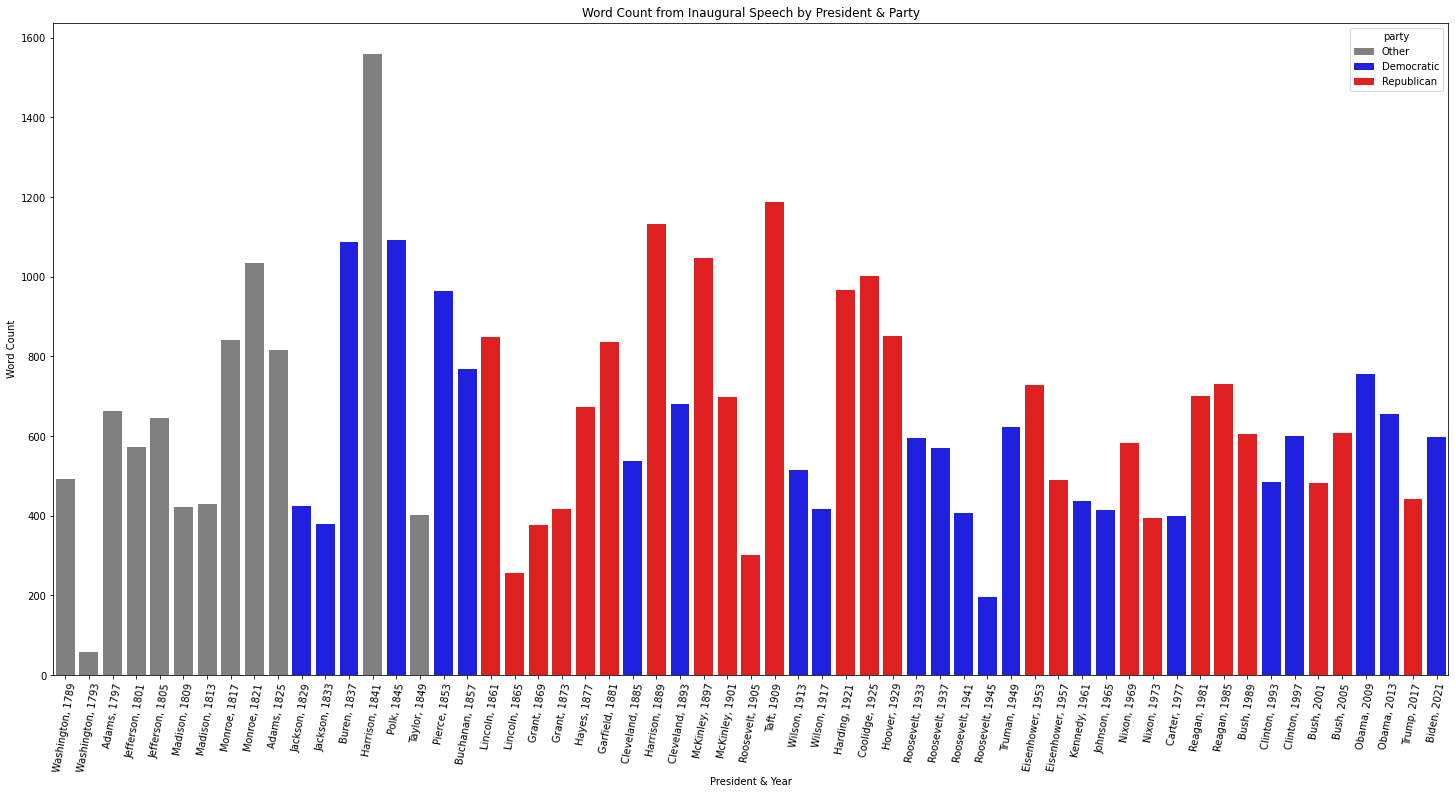

In [9]:
"""Universal function to plot number of vocab words or sentiment. Used for vocab count in this iteration"""

def plot_text_analysis(df:pd.DataFrame, y_value:str='vocab') -> None:
    """
    Plots text analysis of word counts or compound sentiment.
        - df: dataframe with values
        - y_value: value to analyze. Determines analysis type; default='vocab'
    """
    if y_value == 'sentiment':
        y_column = 'compound'
        y_label = 'Sentiment'
    else:
        y_column = 'vocab_count'
        y_label = 'Word Count'
    # set colors 
    color_map = {'Democratic':'blue', 'Republican':'red', 'Other':'grey'}
    # create names
    df['name_year'] = df['full_name'].str.split().str[-1] + ', ' + df['speech_year'].astype(str)
    # set size
    plt.figure(figsize=(25, 12), num=None)
    sns.barplot(data=df,
                x='name_year', 
                y=y_column, 
                hue='party', 
                palette=color_map, 
                dodge=False)
    # rotation
    plt.xticks(rotation=80)
    # labels
    plt.xlabel('President & Year')
    plt.ylabel(y_label)
    plt.title('{} from Inaugural Speech by President & Party'.format(y_label))
    # show
    plt.show()

plot_text_analysis(df)


## 3. What are the five most frequently used words (exclusive of stop words) used by each president? What are the five most frequently words used collectively by all Democratic presidents versus Republican presidents? (2 point)

### Top 5 words used by each president. 

In [10]:
print('Top 5 Words by President:')
for index, row in df.iterrows():
    print('{}, {} : {}'.format(row['full_name'], row['speech_year'], row['top_words']))

Top 5 Words by President:
George Washington, 1789 : [('every', 9), ('government', 9), ('public', 6), ('may', 6), ('citizen', 5)]
George Washington, 1793 : [('shall', 3), ('oath', 2), ('fellow', 1), ('citizen', 1), ('called', 1)]
John Adams, 1797 : [('people', 20), ('nation', 20), ('government', 18), ('may', 13), ('state', 12)]
Thomas Jefferson, 1801 : [('government', 13), ('principle', 9), ('may', 8), ('fellow', 7), ('citizen', 7)]
Thomas Jefferson, 1805 : [('public', 14), ('state', 12), ('citizen', 10), ('may', 10), ('fellow', 8)]
James Madison, 1809 : [('nation', 8), ('public', 6), ('country', 5), ('well', 5), ('right', 5)]
James Madison, 1813 : [('war', 15), ('country', 6), ('united', 5), ('nation', 5), ('state', 5)]
James Monroe, 1817 : [('state', 29), ('government', 22), ('great', 21), ('people', 15), ('citizen', 14)]
James Monroe, 1821 : [('great', 29), ('state', 26), ('power', 20), ('war', 18), ('would', 18)]
John Quincy Adams, 1825 : [('government', 21), ('union', 20), ('upon',

### Top five words used by each party. 



In [11]:
"""We first aggregate all presidents speeches in the Democratic and Republican parties and then ran our counts."""

def get_top_party_words(df:pd.DataFrame) -> dict:
    """Joins all speeches by party, preprocesses text and gets top 5 words by each party."""
    parties = ['Democratic', 'Republican']
    data = {}
    for party in parties:
        # select by party
        selected = df[df['party'] == party]
        # join texts together
        text = " ".join(list(selected['raw_text'].values))
        # preprocess txt
        clean_text = preprocess_text(text)
        # get word frequency
        counts = get_word_frequency(clean_text, LEMMATIZE)
        # add top 5 words for each party
        data[party] = counts.most_common(5)
    return data

words_by_party = get_top_party_words(df)

print('Top 5 words by Party')
for key, value in words_by_party.items():
    print('{}: {}'.format(key, value))

Top 5 words by Party
Democratic: [('people', 238), ('nation', 210), ('government', 210), ('must', 150), ('state', 141)]
Republican: [('people', 289), ('government', 284), ('nation', 229), ('must', 201), ('world', 198)]


### 4. What are the key themes (e.g., freedom, liberty, country, etc.) used by each president in their inaugural speech? (3 points)

In [12]:
""" 
While adverbs and adjectives are great at pointing towards sentiment, nouns indicate the most talked about subject in a text. 

In this case the most popular nouns can point to the key themes of a speech.
"""

def get_theme(text:str, number:int=3) -> list[tuple[Any,int]]:
    """Cleans, lemmatizes and tags words. It filters only nouns and returns top most common to define the theme.
        - text: raw text for processing
        - number: number of nouns to select for there

    Returns: list of most common nouns and the number of iterations
    """
    # clean text
    clean_text = preprocess_text(text)
    # create word list
    word_list = [word for word in clean_text.split()]
    # lemmatize
    wordnet = WordNetLemmatizer()
    lemmatized = [wordnet.lemmatize(w) for w in word_list]
    # gets tag for the part of speech
    tagged_words = pos_tag(lemmatized, tagset='universal')
    # separates the words with the tag-type
    words, tags = zip(*tagged_words)
    # selects only nouns
    nouns = []
    for i, w in enumerate(words):
        if tags[i] == 'NOUN':
            nouns.append(w)
    # selects top 3 nouns
    return Counter(nouns).most_common(number)


def add_themes(df:pd.DataFrame, number:str=3) -> pd.DataFrame:
    """Helper function to add themes into the pandas dataframe
        - df: data with speeches
        - number: number of nouns to pick
    
    Returns: dataframe with themes
    """
    for index, row in df.iterrows():
        # get text
        text = row['raw_text']
        # get themes
        theme = get_theme(text=text, number=number)
        # save into df
        df.loc[index, 'theme'] = str(theme)
    return df

# add themes
df = add_themes(df)

print('Top themes by President:')
for index, row in df.iterrows():
    print('{}, {} : {}'.format(row['full_name'], row['speech_year'], row['theme']))

Top themes by President:
George Washington, 1789 : [('government', 9), ('citizen', 5), ('country', 5)]
George Washington, 1793 : [('citizen', 1), ('voice', 1), ('country', 1)]
John Adams, 1797 : [('people', 20), ('nation', 20), ('government', 18)]
Thomas Jefferson, 1801 : [('government', 13), ('citizen', 6), ('man', 6)]
Thomas Jefferson, 1805 : [('state', 12), ('duty', 8), ('citizen', 8)]
James Madison, 1809 : [('nation', 8), ('country', 5), ('state', 5)]
James Madison, 1813 : [('war', 15), ('country', 6), ('nation', 5)]
James Monroe, 1817 : [('state', 29), ('government', 22), ('people', 15)]
James Monroe, 1821 : [('state', 26), ('power', 20), ('war', 18)]
John Quincy Adams, 1825 : [('government', 21), ('union', 20), ('nation', 15)]
Andrew Jackson, 1829 : [('government', 8), ('power', 6), ('people', 4)]
Andrew Jackson, 1833 : [('government', 14), ('people', 9), ('state', 9)]
Martin Van Buren, 1837 : [('people', 20), ('country', 17), ('institution', 17)]
William Henry Harrison, 1841 : [

### 5. Compute a sentiment (positive/negative) for each presidential speech, and draw a barplot of the sentiment of all presidential speeches in chronological order. Again, color code the speeches as blue for Democrat, red for Republican, and gray for Other. Which of these groups have higher mean sentiment score? Who are the top three presidents with the highest positive sentiment in each group? (2 points)

In [13]:
"""When analyzing sentiment it is recommended to analyze it by sentence and create an average. It is also advised to keep punctuation and capitalization as these changes value of sentiment
    - Keeping punctuation & caps: https://stackoverflow.com/a/45591924  & http://www.nltk.org/howto/sentiment.html
    - Sentence is preferred according to documentation: https://github.com/cjhutto/vaderSentiment/blob/master/vaderSentiment/vaderSentiment.py#L600
"""

def get_document_sentiment(text:str) -> tuple[float]:
    """
    Analyzes sentiment at the sentence level per speech and creates average sentiments. Text needs not be processed as sentiment can be captured from capitalization and annotation.
    
        - text: unfiltered text to be analyzed

    Sentence is preferred according to documentation: https://github.com/cjhutto/vaderSentiment/blob/master/vaderSentiment/vaderSentiment.py#L600

    Returns(tuple): four main values: negative, neutral, positive and compound
    """
    # converting to sentences
    sentence_list = sent_tokenize(text)
    # initialize analyzer
    analyzer = SentimentIntensityAnalyzer()
    # initialize values at zero
    negative = neutral = positive = compound = 0.0
    for sentence in sentence_list:
        score = analyzer.polarity_scores(sentence)
        # print(neg)
        negative += score['neg']
        neutral += score['neu']
        positive += score['pos']
        compound += score['compound']
        # print(score, sent)
    # get size of sentences
    size = len(sentence_list)
    # create averages
    negative = round(negative/size, 4)
    neutral = round(neutral/size, 4)
    positive = round(positive/size, 4)
    compound = round(compound/size, 4)

    return negative, neutral, positive, compound

# get_document_sentiment(text=sample_text)
def add_sentiment_scores(df:pd.DataFrame) -> pd.DataFrame:
    """Helper function adds sentimens to dataframe"""
    for index, row in df.iterrows():
        # get text
        text = row['raw_text']
        # get sentiment scores
        negative, neutral, positive, compound = get_document_sentiment(text)
        # store values
        df.loc[index, 'compound'] = compound
        df.loc[index, 'negative'] = negative
        df.loc[index, 'neutral'] = neutral
        df.loc[index, 'positive'] = positive
    return df

df = add_sentiment_scores(df)


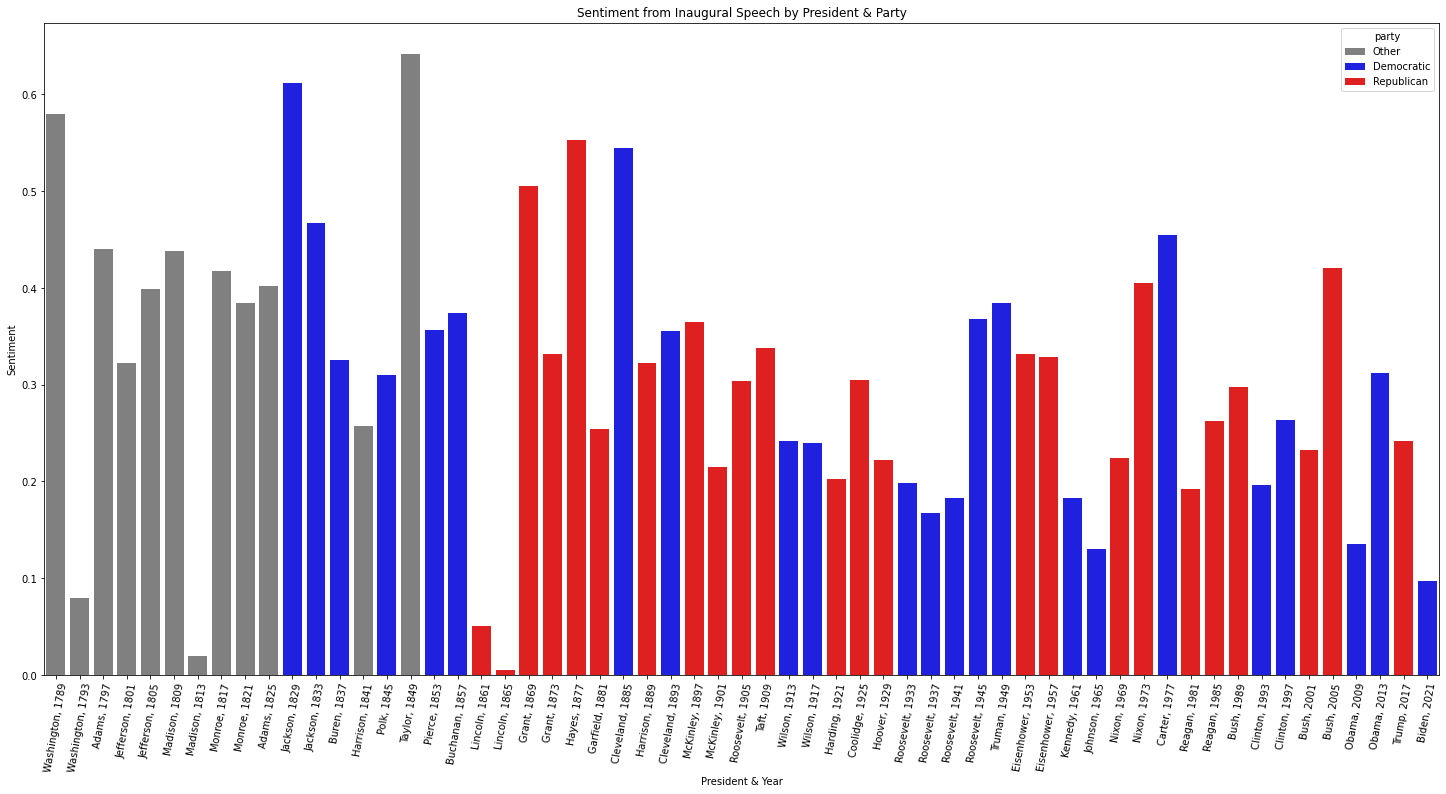

In [14]:
""" Universal function to plot text analysis by presidents and parties this time used to pick avg. compound sentiment"""

plot_text_analysis(df, 'sentiment')

Out of the three parties the sentiment average is highest for the Other (older parties like Wig, Federalist), followed by the Democratic and the Republican party

In [15]:
"""Average sentiment per party sorted"""

df.groupby('party').agg({'compound':'mean'}).sort_values('compound', ascending=False)

,compound
party,
Other,0.365025
Democratic,0.300000
Republican,0.287975


The top 3 presidents who had the highest positive sentiments are below per each party

In [16]:
""" Function to get top sentiment per party"""

def top_president_sentiments(df, party:str, sentiment:str='positive', number:int=3) -> pd.DataFrame:
    """Given a party gives the top number of presidents with positive sentiment.
        - df: dataframe with sentiment scores
        - party: party being analyzed (Other, Democratic, Republican)
        - semtiment: sentiment to be analyzed; default = 'positive'
        - number: top number of presidents
        
    Returns: dataframe with top president by sentiments
    """
    filter = df.party.eq(party)
    return df[filter].sort_values(sentiment, ascending=False)[:number][['speech_year', 'full_name', 'party', sentiment]]

""" Top 3 Other presidents"""

top_president_sentiments(df, 'Other')

,speech_year,full_name,party,positive
7,1817,James Monroe,Other,0.2071
15,1849,Zachary Taylor,Other,0.1930
2,1797,John Adams,Other,0.1818


In [17]:
"""Top 3 Democratic presidents"""

top_president_sentiments(df, 'Democratic')

,speech_year,full_name,party,positive
47,1977,Jimmy Carter,Democratic,0.2581
40,1949,Harry S. Truman,Democratic,0.2195
39,1945,Franklin D. Roosevelt,Democratic,0.1990


In [18]:
"""Top 3 Republican presidents"""

top_president_sentiments(df, 'Republican')

,speech_year,full_name,party,positive
54,2005,George W. Bush,Republican,0.2197
42,1957,Dwight D. Eisenhower,Republican,0.2059
20,1869,Ulysses S. Grant,Republican,0.2019


In [19]:

# # TODO
# # sample_text

# class TextProcessor(object):
#     def __init__(self, abbreviations:dict[str,set], added_stopwords:list, lemmatize:bool=True, language:str='english') -> None:
#         super().__init__()
#         self.language = language
#         self.abbreviations = abbreviations
#         self.added_stopwords = added_stopwords
#         self.lemmatize = lemmatize

#     def __str__(self):
#         return f"<GeneralTextProcessor>"

#


#     # optional: step 4
#     def get_word_frequency(self, text:str, lemmatize:bool=True) -> Counter:
#         # format to word list
#         words = self.list_words(text)
#         # lemmatize words
#         if lemmatize:
#             wordnet = WordNetLemmatizer()
#             words = [wordnet.lemmatize(w) for w in words]
#         # create counter
#         counts = Counter(words)
#         # print('counts:',len(counts))
#         return counts
    
# text_processor = TextProcessor()
# # text_processor.list_sentences(sample_text)
# word_replacements = {'united_states':{'U.S.', 'US'}}
# # text_processor.replace_abbreviations(sample_text, word_replacements)
# # clean_text = text_processor.remove_punctuation(sample_text)
# added_stopwords = ['us']
# # text_processor.remove_stopwords(clean_text, )

# test_sentence = text_processor.list_sentences(sample_text)[1]
# test_sentence = text_processor.replace_abbreviations(test_sentence, word_replacements)
# test_sentence = text_processor.remove_punctuation(test_sentence)
# text_processor.remove_stopwords(test_sentence, added_stopwords)

# def get_sentiment():
#     pass

# func5: for each president 
#  get list of sentences 
#      for each sentece
#           processed text (remove punctuations)
#           get sentiment value per sentence 
#           aggregate sentiment
#  return sentiment value into df 0

# func6: plot sent value per president - refactor plot_vocab

Submit your code and results on a Jupyter Notebook file, and your data corpus as a csv file.

NOTE: Points will be deducted for copy-and-paste code from the class examples without thinking about their appropriateness for the assignment. Your code must be compact, free of errors, avoid unnecessary details not asked in the question, use functions and loops as appropriate, and use some comment statements. You will lose points if you fail to adhere to these common coding expectations.